# 1.Project Overview

* __Objective__ : Track price changes in maggi 12-pack over time
* __Why__ : To detect inflation trend
* __Data sources__ : Wayback machine - previous html pages of amazon listing
* __Tools__ : BeautifulSoup,Sqlite,numpy,pandas,matplotlib,seaborn

__Business question__ : Did nestle increase maggi price faster than food inflation ?

In [1]:
import os
import time
import re
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import seaborn as sns
from bs4 import BeautifulSoup
import sqlite3
from tqdm import tqdm

In [2]:
# wayback cdx config
url='http://web.archive.org/cdx/search/cdx'
user_agent='Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/142.0.0.0 Safari/537.36'
headers={'User_Agent':user_agent}
target='www.amazon.in/dp/B07B4KQRZG*'
params={'url':target,
        'output':'json',
        'filter':'statuscode:200',
        'fl':'original,timestamp',
        'collapse':'timestamp:6'}


# file paths
maggi_scraped_df_path=os.path.join('data','processed','maggi_scraped_df.csv')
maggi_raw_data_path=os.path.join('data','raw','maggi_raw_data.json')
general_cpi_path=os.path.join('data','external','General_Index_Sep20-To-Oct25.csv')
food_cpi_path=os.path.join('data','external','Food_Price_Index_Sep20-To-Oct25 .csv')
maggi_cleaned_prices_path=os.path.join('data','processed','maggi_cleaned_prices.csv')

os.makedirs(os.path.dirname(maggi_scraped_df_path),exist_ok=True)
os.makedirs(os.path.dirname(maggi_raw_data_path),exist_ok=True)
os.makedirs(os.path.dirname(general_cpi_path),exist_ok=True)
os.makedirs(os.path.dirname(food_cpi_path),exist_ok=True)
os.makedirs(os.path.dirname(maggi_cleaned_prices_path),exist_ok=True)
os.makedirs('outputs',exist_ok=True)
# to prevent ipban in wayback machine 
timeout=10
sleep_time=np.random.randint(1,5,1)[0]

# Visulazation 
presentation_graphs_dict = {
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'font.family': 'sans-serif',
    'font.sans-serif': ['Urbanist', 'DejaVu Sans'] 
}

# database name & schema
db_name='inflation.db'
product_data=[('Maggi 2-Minute Noodles Masala (Pack of 12)','INR')]
db_schema={ 'products': '''product_id integer primary key autoincrement, 
                           product_name text unique, 
                           base_currency text''',
            'price_history':'''record_id integer primary key autoincrement,
                               product_id integer,
                               record_date text,
                               price real,
                               weight_grams real,
                               foreign key(product_id) references products(product_id),
                               unique(product_id,record_date)''',
            'economic_indicators':'''record_date text primary key,
                                     general_cpi real,
                                     food_cpi real'''}

# 2.Url Collection Summary

* covers data from __2020__ to __2023__
* __total Unique entries__ : 373
* used statuscode: 200 and collapse so only get valid pages and no dublicates

In [3]:
def get_response(method,url,headers=None,params=None):
    """ Excutes https request with randomized delays and error handlings
    Args:
        method(str):'GET' or 'POST'
        url(str):the target url
        headers(dict,optional):browser to avoid bot detection
        params(dict,optional):url parameters
        
    Returns:
        requests.Response object if success either return None"""

    # prevents from hitting ratelimit or ipban
    time.sleep(sleep_time)
    response=None
    try :
      response=requests.request(method='GET',url=url,headers=headers,params=params,timeout=timeout)
    
    except requests.exceptions.HTTPError as errh:
        print(f'HTTP Error for {url} : {errh}')
    except requests.exceptions.ConnectionError as errc:
        print(f'Connection Error for {url}: {errc}')
    except requests.exceptions.Timeout as errt:
        print(f'Timeout Error for {url}: {errt}')
    except requests.exceptions.RequestException as err:
        print(f'Something Else for {url}: {err}')
    return response

In [4]:
# to prevent everytime asking for the data from wayback machine

if os.path.exists(maggi_raw_data_path):
    
    with open(maggi_raw_data_path) as f:
        maggi_raw_data=json.load(f)
        
    print(f'maggi_raw_data loaded succefully type is :{type(maggi_raw_data)} and length is : {len(maggi_raw_data)}')

else :
    print(f'file not exists at {maggi_raw_data_path} fetching data from wayback machine')
    
    response=get_response(method='GET',url=url,headers=headers,params=params)
    if response is not None and response.status_code==200:
        maggi_raw_data=response.json()
        print(f'maggi_raw_data fetched succefully type is :{type(maggi_raw_data)} and length is : {len(maggi_raw_data)}')

        # to load the data latter 
        with open(maggi_raw_data_path,'w+') as f:
            json.dump(maggi_raw_data,f)
        print(f'file saved at {maggi_raw_data_path}')
    else:
        print('failed to retrieve data')

maggi_raw_data loaded succefully type is :<class 'list'> and length is : 848


In [5]:
def df_cleaner(df,column_name='record_date'):
    """ Convert record_date column to datatype datetime, sortvalues based on date and reset index
    Args : 
        df(dataframe) : dataframe object
        column_name(str) : column you want to convert to datetime object
    return 
        df(clean version of given dataframe): """
    
    df[column_name]=df[column_name].astype('datetime64[ns]')
    df=df.sort_values(by=column_name)
    df=df.reset_index(drop=True)
    return df

In [6]:
maggi_raw_df=pd.DataFrame(maggi_raw_data[1:],columns=maggi_raw_data[0])

maggi_raw_df['record_date']=maggi_raw_df['timestamp'].astype('datetime64[ns]').apply(lambda x:x.date())

maggi_raw_df.drop_duplicates(subset=['record_date'],inplace=True)
maggi_raw_df=df_cleaner(maggi_raw_df)

# this urls allows us to scrape data
maggi_raw_df['webpages']='https://web.archive.org/web/'+maggi_raw_df['timestamp']+'/'+maggi_raw_df['original']
maggi_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   original     373 non-null    object        
 1   timestamp    373 non-null    object        
 2   record_date  373 non-null    datetime64[ns]
 3   webpages     373 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 11.8+ KB


# 3.Data Collection Summary

* Used __beautifulSoup__ to extract title and price from urls
* Using __regular expression__ extract weight and no of packs from title
* __total non-null entries__ : 169

In [7]:
def create_soup(html_content):
    """create a beautiful soup object use for scarping"""
    soup=BeautifulSoup(html_content,'html.parser')
    return soup
    
def extraction(soup):
    """Find title and price from html content.Amazon frequently change their price class
    So it handle it with cases
    
    Args : 
        beautiful soup object
        
    Return : 
        result dict contains title and price if not find infomation returns None"""
    
    result={'title':None,'price':None}

    if soup.find(id='productTitle') is None:
      return None
    else:
      webpage_title=soup.find(id='productTitle').get_text().strip()
      result['title']=webpage_title

    # amazon change classes frequent so need to check cases
    if soup.find('span',{'class':"a-price-whole"}) is not None:
      webpage_price=soup.find('span',{'class':"a-price-whole"}).get_text().strip()

    elif soup.find(id='priceblock_dealprice') is not None:
      webpage_price=soup.find(id='priceblock_dealprice').get_text().strip()

    elif soup.find(id='priceblock_ourprice') is not None:
      webpage_price=soup.find(id='priceblock_ourprice').get_text().strip()

    else:
      webpage_price=None

    if webpage_price is not None:
      webpage_final_price=re.sub(r'[^\d.]','',webpage_price)
      result['price']=float(webpage_final_price)

    else:
      result['price']=webpage_price

    return result

In [8]:
if os.path.exists(maggi_scraped_df_path) :
    print('Found maggi_scraped_df loaded')
    maggi_scraped_df=pd.read_csv(maggi_scraped_df_path)
    print(maggi_scraped_df.head())
else :
    print(f'File not exists at /{maggi_scraped_df_path}, confirm file location or start scraping data using the script below')

Found maggi_scraped_df loaded
                                             title  price
0  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  144.0
1  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6
2  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6
3  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6
4  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  129.6


In [9]:
## !! WARNING:scraping more than 373 urls takes time, so you can direct use the maggi_scraped_df from data/processed/maggi_scraped_df.csv
## If you have enough time to spend give it a shot. 

# all_data=[]
# for webpage in tqdm(maggi_raw_df['webpages']):
#     response=get_response(method='GET',url=webpage,headers=headers)
#     if response is None:
#         print(f'failed to fetch : {webpage}')
#         continue
#     html_content=response.text
#     soup=create_soup(html_content)
#     clean_data=extraction(soup)
#     if clean_data is None:
#         continue
#     all_data.append(clean_data)

# print(f'extrection complete. valid recors are {len(all_data)}')

In [10]:
# maggi_scraped_df=pd.DataFrame(all_data)
# maggi_scraped_df.to_csv(maggi_scraped_df_path,index=False)

In [11]:
maggi_concat_df=pd.concat([maggi_raw_df,maggi_scraped_df],axis=1)
maggi_concat_df=maggi_concat_df.dropna()
maggi_concat_df=df_cleaner(maggi_concat_df)
maggi_concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   original     169 non-null    object        
 1   timestamp    169 non-null    object        
 2   record_date  169 non-null    datetime64[ns]
 3   webpages     169 non-null    object        
 4   title        169 non-null    object        
 5   price        169 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 8.0+ KB


In [12]:
def extract_product_details(title_text):
  """Use regex expressions to find no of packs , weight and unit of weight from the title
    Args : 
        title_text(srt)
    Returns:
        dict containing information releted to the product"""
  result={}
  if title_text is not None:

    no_of_packs=1
    grps=re.search(r'Pack of\s+(\d+)',title_text,flags=re.IGNORECASE)
    if grps:
      no_of_packs=int(grps.group(1))
      result['no_of_packs']=no_of_packs

    grps2=re.search(r'(\d*\.?\d+)\s*(g|kg|gm|gram|ml|l)',title_text,flags=re.IGNORECASE)
    if grps2:
      weight_per_pack=float(grps2.group(1))
      unit=grps2.group(2)
      result['weight_per_pack']=weight_per_pack
      result['unit']=unit
        # the weight contains only two values 70 or 840 so if the weight is already 840 no need to multiply it by the no of packs
      if weight_per_pack==840 :
        total_weight=weight_per_pack
      else:
        total_weight=weight_per_pack*no_of_packs

      result['total_weight']=total_weight

    return result
  else :
    print(f"Warning: Could not extract weight from title: {title_text}")
    result={'weight_per_pack':None,'unit':None,'no_of_packs':None,'total_weight':None}
    return result

In [13]:
maggi_information_df=maggi_concat_df['title'].apply(extract_product_details).apply(pd.Series)
# to check if there is any other unit then gram
print(maggi_information_df['unit'].unique())

['g' 'G']


In [14]:
maggi_all_df=pd.concat([maggi_concat_df,maggi_information_df],axis=1)

# it's a standard way to compair product prices
maggi_all_df['price_per_100g']=(maggi_all_df['price']/maggi_all_df['total_weight'])*100
maggi_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   original         169 non-null    object        
 1   timestamp        169 non-null    object        
 2   record_date      169 non-null    datetime64[ns]
 3   webpages         169 non-null    object        
 4   title            169 non-null    object        
 5   price            169 non-null    float64       
 6   no_of_packs      155 non-null    float64       
 7   weight_per_pack  169 non-null    float64       
 8   unit             169 non-null    object        
 9   total_weight     169 non-null    float64       
 10  price_per_100g   169 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 14.6+ KB


# 4.Database summary 

* __tables__ : products , price_history , economic indicators
* __Handling__ : use insert or ignore / try expect to prevent dublicate entries

In [15]:
# using with to prevent lock in database
with sqlite3.connect(db_name) as con:
    cur=con.cursor()
    # sqlite3 doesn't on foreign key automatic...
    cur.execute('PRAGMA foreign_keys=ON;')
    
    # define schema in start for code accecibility
    for table_name,columns in db_schema.items():
        cur.execute(f'create table if not exists {table_name} ({columns})')
    # confirmation...
    res=cur.execute('select name from sqlite_master where type="table"')
    print(res.fetchall())

    cur.executemany("""insert or ignore into products (product_name,base_currency) values
                (?,?)""",product_data)

    con.commit()    
    # confirming
    res=cur.execute('select * from products')
    print('products :',res.fetchall())

[('products',), ('sqlite_sequence',), ('price_history',), ('economic_indicators',)]
products : [(1, 'Maggi 2-Minute Noodles Masala (Pack of 12)', 'INR')]


In [16]:

# to prevent error while adding the data from the df
maggi_sql_df=maggi_all_df.rename(columns={'total_weight':'weight_grams'})
maggi_sql_df['product_id']=1

# database doesn't recognize datetime format so it will save the date in long string.
maggi_sql_df['record_date']=maggi_sql_df['record_date'].astype('str')

maggi_sql_df=maggi_sql_df.drop(['original','timestamp','webpages','title','no_of_packs','weight_per_pack','unit','price_per_100g'],axis=1)
maggi_sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   record_date   169 non-null    object 
 1   price         169 non-null    float64
 2   weight_grams  169 non-null    float64
 3   product_id    169 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 5.4+ KB


In [17]:
# General index & Consumer food price index downloaded from https://cpi.mospi.gov.in


if os.path.exists(general_cpi_path):
    print(f'{general_cpi_path} found file loaded')
    general_index_df=pd.read_csv(general_cpi_path,header=1)
else :
    print(f'{general_cpi_path} not found')

if os.path.exists(food_cpi_path):
    print(f'{food_cpi_path} found file loaded')
    food_price_index_df=pd.read_csv(food_cpi_path,header=1)
else :
    print(f'{general_cpi_path} not found')


general_index_df['Year']=general_index_df['Year'].astype('str')
general_index_df['Date']=general_index_df['Month']+'-'+general_index_df['Year']
# to match the dates with maggi_sql_df
general_index_df['Date']=general_index_df['Date'].astype('datetime64[ns]').astype('str')
general_index_df=general_index_df.drop(columns=['State','Group','Sub Group','Description','Rural','Urban','Status','Month','Year','Unnamed: 10'])

food_price_index_df['Year']=food_price_index_df['Year'].astype('str')
food_price_index_df['Date']=food_price_index_df['Month']+'-'+food_price_index_df['Year']
# to match dates with maggi_sql_df
food_price_index_df['Date']=food_price_index_df['Date'].astype('datetime64[ns]').astype('str')
food_price_index_df=food_price_index_df.drop(columns=['State','Group','Sub Group','Description','Rural','Urban','Status','Month','Year','Unnamed: 10'])

general_index_df.rename(columns={'Combined':'general_cpi','Date':'record_date'},inplace=True)
food_price_index_df.rename(columns={'Combined':'food_cpi','Date':'record_date'},inplace=True)

# concating
cpi_df=pd.merge(general_index_df,food_price_index_df,on='record_date')
cpi_df.info()

data/external/General_Index_Sep20-To-Oct25.csv found file loaded
data/external/Food_Price_Index_Sep20-To-Oct25 .csv found file loaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   general_cpi  62 non-null     float64
 1   record_date  62 non-null     object 
 2   food_cpi     62 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [18]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    try:
        maggi_sql_df.to_sql('price_history', con=con, if_exists='append', index=False)
    except sqlite3.IntegrityError:
        print("Some data already exists in price_history. Ignoring duplicates.")
    # confirming..
    res=cur.execute('select count(*) from price_history' )
    print('price_history :',res.fetchone())
    
    try:
        cpi_df.to_sql('economic_indicators',con=con,if_exists='append',index=False,method='multi')
    except sqlite3.IntegrityError:
        print("Some data already exists in economic_indicators. Ignoring duplicates.")
    # confirming..
    res=cur.execute('select count(*) from economic_indicators')
    print('economic_indicators :',res.fetchone())

Some data already exists in price_history. Ignoring duplicates.
price_history : (169,)
Some data already exists in economic_indicators. Ignoring duplicates.
economic_indicators : (62,)


# 5.Sql operations

__5.1 What are the dates where maggi has highest and lowest prices__

In [19]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    res=cur.execute( 'select price from price_history  order by price desc limit 1 ')
    print(res.fetchall())

[(183.0,)]


In [20]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    res=cur.execute( 'select price from price_history order by price limit 1')
    print(res.fetchall())

[(129.0,)]


__5.2 How many records do we have per Year?__

In [21]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    res=cur.execute( ''' with year_table as (select strftime('%Y',record_date) as yr from price_history)
                                select yr,count(*) from year_table group by yr''')
    print(res.fetchall())

[('2020', 15), ('2021', 29), ('2022', 81), ('2023', 44)]


# 6. Exploratory Data Analysis(EDA)

* __6.1 loading data from the database and resapmle maggi data on months for better compartion with Influation Index__

In [22]:
with sqlite3.connect(db_name) as con:
    cur=con.cursor()

    maggi_df=pd.read_sql('select record_date,price,weight_grams from price_history',con=con)
    cpi_df=pd.read_sql('select * from economic_indicators',con=con)

maggi_df=df_cleaner(maggi_df)
# to prevent noise in the price from amazon
maggi_df['price_per_100g']=(maggi_df['price']/maggi_df['weight_grams'])*100
maggi_df = maggi_df.resample('MS', on='record_date').mean().ffill().reset_index()
maggi_df=maggi_df.drop([4,31,32]).reset_index(drop=True)

maggi_bi_df=maggi_df.drop('price_per_100g',axis=1)
maggi_bi_df['record_date']=maggi_bi_df['record_date'].astype('str')

maggi_merge_bi_df=pd.merge(maggi_bi_df,cpi_df)
maggi_merge_bi_df.to_csv(maggi_cleaned_prices_path,index=False)

In [23]:
maggi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   record_date     31 non-null     datetime64[ns]
 1   price           31 non-null     float64       
 2   weight_grams    31 non-null     float64       
 3   price_per_100g  31 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.1 KB


* __6.2 Descriptive Stat for price_per_100g column__
    * min price = 15.42
    * max price = 19.28
    * mean = 17.84
    * median = 18.715
    * std = 1.343

In [24]:
print(maggi_df['price_per_100g'].median())
maggi_df.describe()
maggi_df['record_date']

18.622448979591837


0    2020-09-01
1    2020-10-01
2    2020-11-01
3    2020-12-01
4    2021-02-01
5    2021-03-01
6    2021-04-01
7    2021-05-01
8    2021-06-01
9    2021-07-01
10   2021-08-01
11   2021-09-01
12   2021-10-01
13   2021-11-01
14   2021-12-01
15   2022-01-01
16   2022-02-01
17   2022-03-01
18   2022-04-01
19   2022-05-01
20   2022-06-01
21   2022-07-01
22   2022-08-01
23   2022-09-01
24   2022-10-01
25   2022-11-01
26   2022-12-01
27   2023-01-01
28   2023-02-01
29   2023-03-01
30   2023-06-01
Name: record_date, dtype: datetime64[ns]

__6.3 Visualization : Price Over Time__

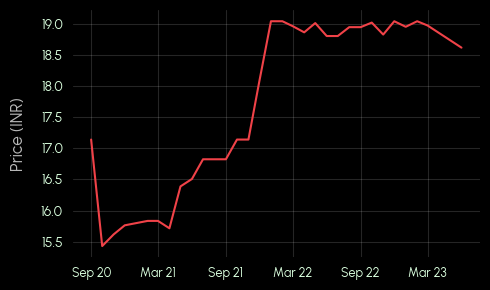

In [38]:
import matplotlib.font_manager as fm 

fm.fontManager.addfont('fonts/Urbanist-Regular.ttf')

presentation_graphs_dict = {
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'font.family': 'sans-serif',
    'font.sans-serif': ['Urbanist', 'DejaVu Sans'] 
}
with sns.axes_style('dark',presentation_graphs_dict): 

    plt.figure(figsize=(5,3))
    ax=plt.gca()

    sns.lineplot(maggi_df,x='record_date',y='price_per_100g',lw=1.5 , color='#f04248')

    sns.despine(left=True,bottom=True)

    plt.grid(True, alpha=0.15, ls='-', color='white')    

    plt.ylabel('Price (INR)',color='#e6e6e6',fontsize=12,labelpad=10,alpha=0.8)
    plt.xlabel('')
    
    manual_ticks = ['2020-09-01', '2021-03-01', '2021-09-01', '2022-03-01', '2022-09-01', '2023-03-01']
    manual_labels = ['Sep 20', 'Mar 21', 'Sep 21', 'Mar 22', 'Sep 22', 'Mar 23']

    plt.xticks(
        ticks=pd.to_datetime(manual_ticks), 
        labels=manual_labels,
        fontsize=9, 
        rotation=0, 
        color='#daffde'
    )
    plt.yticks(color='#daffde')
    
    plt.tight_layout()
    plt.savefig('outputs/Price Over Years.png', dpi=200, transparent=True, bbox_inches='tight')
    plt.show()

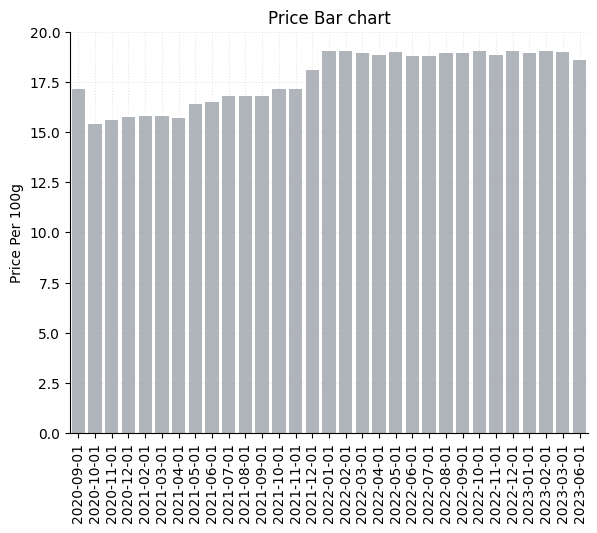

In [26]:
sns.barplot(data=maggi_df,y='price_per_100g',x='record_date',color='#adb5bd')
sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.xticks(rotation=90)
plt.ylabel('Price Per 100g')
plt.xlabel('')
plt.title('Price Bar chart')

plt.show()

__6.4 Monthly Price Change__

In [27]:
maggi_df=maggi_df.set_index('record_date')
maggi_df['mom%']=(maggi_df.pct_change()['price_per_100g'])*100
maggi_df.reset_index(inplace=True)
maggi_df.head()

,record_date,price,weight_grams,price_per_100g,mom%
0,2020-09-01,144.000,840.0,17.142857,NaN
1,2020-10-01,129.600,840.0,15.428571,-10.000000
2,2020-11-01,131.175,840.0,15.616071,1.215278
3,2020-12-01,132.400,840.0,15.761905,0.933867
4,2021-02-01,133.000,840.0,15.833333,0.453172


Text(0.5, 1.0, 'Price % change over months')

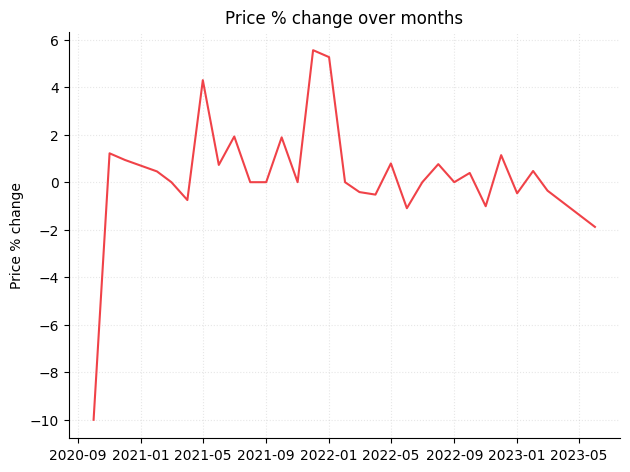

In [28]:
sns.lineplot(data=maggi_df,x='record_date',y='mom%',color='#f04248')

sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.ylabel('Price % change')
plt.xlabel('')
plt.title('Price % change over months')

In [29]:
maggi_df.describe()['mom%']

count    30.000000
mean      0.309609
min     -10.000000
25%      -0.401786
50%       0.000000
75%       0.897561
max       5.555556
std       2.589439
Name: mom%, dtype: float64

# 7.Price Distribution 
* __1.box plot__ - shows outliers
* __2.histogram__ - shows distribution 

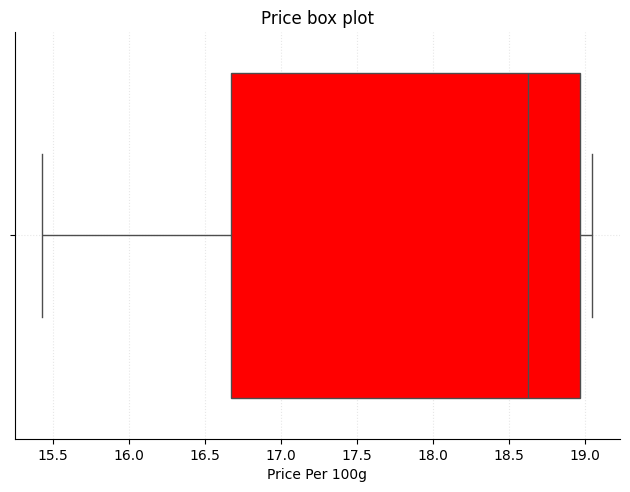

In [30]:
sns.boxplot(data=maggi_df,x='price_per_100g',color='red',saturation=1.5)

sns.despine()

plt.grid(alpha=0.3,ls='dotted')
plt.tight_layout()

plt.ylabel('')
plt.xlabel('Price Per 100g')
plt.title('Price box plot')
plt.show()

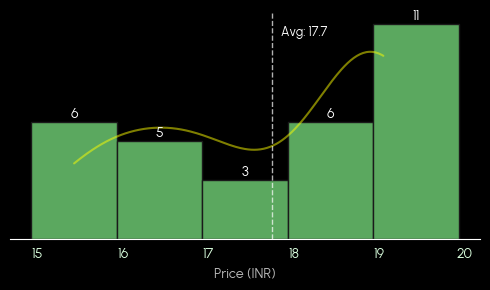

In [40]:
with sns.axes_style('dark',presentation_graphs_dict):

    mean_price=maggi_df['price_per_100g'].mean()
    plt.figure(figsize=(5,3))

    ax=sns.histplot(data=maggi_df,
                 x='price_per_100g',
                 kde=True,
                 color='#66BB6A',  
                 edgecolor='#1a1a1a', 
                 discrete=True,   
                 alpha=0.9,
                 )
    ax.lines[0].set_color('#FFFF00')
    ax.lines[0].set_alpha(0.5)

    plt.axvline(mean_price, color='white', linestyle='--', linewidth=1, alpha=0.7)
    plt.text(mean_price + 0.1, ax.get_ylim()[1]*0.9, f'Avg: {mean_price:.1f}', 
             color='white', fontsize=9, rotation=0)
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(x=p.get_x() + p.get_width() / 2, 
                    y=height + 0.2, 
                    s=f'{int(height)}', 
                    ha='center', color='white', fontsize=10, fontweight='bold')

    sns.despine(left=True)
    
    plt.tight_layout()

    plt.ylabel('')
    plt.xlabel('Price (INR)',color='#e6e6e6',alpha=0.8)
    plt.xticks(color='#daffde',)
    plt.yticks([])

    
    plt.tight_layout()
    plt.savefig('outputs/Price Distribution.png', dpi=200, transparent=True, bbox_inches='tight')
    plt.show()
    

# 8.Business Insights

* __Merge both dataframe based on record_date__
* __Corrlation (price_per_100g with food_cpi)__ : 0.69
* __Normalize value__
* Plot __maggi_price__ and __food_inflation__
* Plot __ratio__

In [32]:
cpi_df=df_cleaner(cpi_df)

In [33]:
merge_df=pd.merge(maggi_df,cpi_df,on='record_date')
merge_df=df_cleaner(df=merge_df)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   record_date     31 non-null     datetime64[ns]
 1   price           31 non-null     float64       
 2   weight_grams    31 non-null     float64       
 3   price_per_100g  31 non-null     float64       
 4   mom%            30 non-null     float64       
 5   general_cpi     31 non-null     float64       
 6   food_cpi        31 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.8 KB


In [34]:
merge_df.corr(numeric_only=True)['price_per_100g']

price             1.000000
weight_grams           NaN
price_per_100g    1.000000
mom%              0.163207
general_cpi       0.873524
food_cpi          0.789712
Name: price_per_100g, dtype: float64

In [35]:
# In first entry there is very high value of price due to amazon price flcuation so i have to use 4 days average. for better results 
base_price=merge_df['price_per_100g'][:4].mean()
base_food_cpi=merge_df['food_cpi'][:4].mean()

merge_df['maggi_index']=(merge_df['price_per_100g']/base_price)*100
merge_df['food_inflation']=(merge_df['food_cpi']/base_food_cpi)*100

print(merge_df['price_per_100g'][:4])

0    17.142857
1    15.428571
2    15.616071
3    15.761905
Name: price_per_100g, dtype: float64


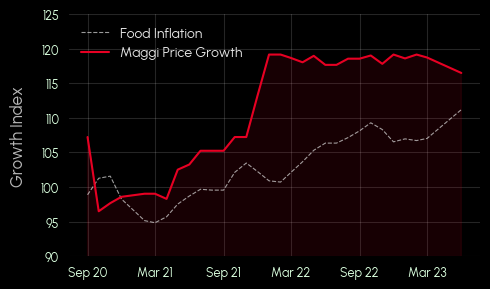

In [44]:
with sns.axes_style('dark', presentation_graphs_dict):
    plt.figure(figsize=(5, 3))

    sns.lineplot(
        data=merge_df,
        x='record_date',
        y='food_inflation',
        color='#dddddd', 
        alpha=0.7,       
        lw=0.8,
        linestyle='--',  
        label='Food Inflation'
    )

    sns.lineplot(
        data=merge_df,
        x='record_date',
        y='maggi_index',
        color='#E70023',
        lw=1.5, # Slightly thicker
        label='Maggi Price Growth' 
    )
    plt.fill_between(
        merge_df['record_date'], 
        merge_df['maggi_index'], 
        color='#E70023', 
        alpha=0.1
    )

    sns.despine(left=True, bottom=True)

    plt.xticks(
        ticks=pd.to_datetime(manual_ticks), 
        labels=manual_labels,
        fontsize=9, 
        rotation=0, 
        color='#daffde',
        fontweight='bold'
    )

    plt.ylim(90,125)
    plt.yticks(
        fontsize=9, 
        color='#daffde'
    )

    plt.xlabel('')
    plt.ylabel('Growth Index', color='#e6e6e6', fontsize=12, labelpad=10,alpha=0.8)
    
    plt.grid(True, alpha=0.15, ls='-', color='white') 

    plt.legend(
        labelcolor='#e6e6e6',
        fontsize=10, 
        frameon=False,
        loc='upper left' 
    )

    plt.tight_layout()
    plt.savefig('outputs/maggi index vs food index.png', dpi=200, transparent=True, bbox_inches='tight')
    plt.show()

In [328]:
merge_df['ratio']=merge_df['maggi_index']/merge_df['food_inflation']

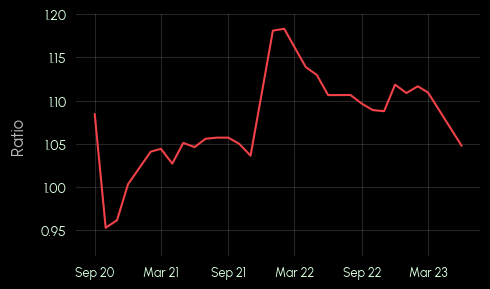

In [329]:
fm.fontManager.addfont('fonts/Urbanist-Regular.ttf')
with sns.axes_style('dark',presentation_graphs_dict): 

    plt.figure(figsize=(5,3))
    ax=plt.gca()

    sns.lineplot(merge_df,x='record_date',y='ratio',lw=1.5 , color='#f04248')

    sns.despine(left=True,bottom=True)

    plt.grid(True, alpha=0.15, ls='-', color='white')    
    plt.ylabel('Ratio',color='#e6e6e6',fontsize=12,labelpad=10,alpha=0.8)
    plt.xlabel('')
    plt.xticks(color='#daffde')
    plt.yticks(color='#daffde')
    
    manual_ticks = ['2020-09-01', '2021-03-01', '2021-09-01', '2022-03-01', '2022-09-01', '2023-03-01']
    manual_labels = ['Sep 20', 'Mar 21', 'Sep 21', 'Mar 22', 'Sep 22', 'Mar 23']

    plt.xticks(
        ticks=pd.to_datetime(manual_ticks), 
        labels=manual_labels,
        fontsize=9, 
        rotation=0, 
        color='#daffde'
    )
    plt.ylim(0.92,1.2)
    plt.tight_layout()
    plt.savefig('outputs/ratio graph.png', dpi=200, transparent=True, bbox_inches='tight')
    plt.show()

# Conclusion

__Anticipatory Pricing (2021-2022)__: Maggi prices spiked before the general inflation peak. By Jan 2022, Maggi's price index (111.1) was significantly higher than the general Food Inflation index (102.0).

__Inflation Catch-Up (2022-2023)__: Post-2022, Maggi prices stabilized (flat line) while general inflation continued to rise (102 $\to$ 108). This suggests Nestle front-loaded their price hikes to secure margins early.

__No Shrinkflation__: Weight remained constant at 840g, confirming a pure price-strategy approach.